# **1. Perkenalan Dataset**


Proyek ini bertujuan untuk melakukan klasifikasi gambar berdasarkan dataset **"A Large-Scale Rice Image Dataset"**. Dataset ini merupakan kumpulan data gambar yang substansial dan sering digunakan untuk melatih model *deep learning* dalam tugas klasifikasi citra, khususnya untuk varietas beras.

**Sumber Dataset:**

  * **Kaggle:** [Rice Image Dataset](https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset)
  * **Situs Kreator:** [Murat KOKLU Datasets](https://www.muratkoklu.com/datasets/)

**Detail Dataset:**
Dataset ini mencakup lima varietas beras yang berbeda, yaitu:

  * Arborio
  * Basmati
  * Ipsala
  * Jasmine
  * Karacadag

Total dataset terdiri dari **75.000 gambar**, dengan **15.000 gambar** untuk setiap varietas, menjadikannya dataset yang seimbang (*balanced*) dan cocok untuk melatih model klasifikasi.

**Sitasi Akademis:**
Jika menggunakan dataset ini untuk penelitian, sangat disarankan untuk mengutip karya ilmiah dari para kreator dataset:

>   * Koklu, M., Cinar, I., & Taspinar, Y. S. (2021). Classification of rice varieties with deep learning methods. *Computers and Electronics in Agriculture, 187*, 106285. [https://doi.org/10.1016/j.compag.2021.106285](https://doi.org/10.1016/j.compag.2021.106285)
>   * Cinar, I., & Koklu, M. (2021). Determination of Effective and Specific Physical Features of Rice Varieties by Computer Vision In Exterior Quality Inspection. *Selcuk Journal of Agriculture and Food Sciences, 35(3)*, 229-243. [https://doi.org/10.15316/SJAFS.2021.252](https://doi.org/10.15316/SJAFS.2021.252)
>   * Cinar, I., & Koklu, M. (2022). Identification of Rice Varieties Using Machine Learning Algorithms. *Journal of Agricultural Sciences*. [https://doi.org/10.15832/ankutbd.862482](https://www.google.com/search?q=https://doi.org/10.15832/ankutbd.862482)
>   * Cinar, I., & Koklu, M. (2019). Classification of Rice Varieties Using Artificial Intelligence Methods. *International Journal of Intelligent Systems and Applications in Engineering, 7(3)*, 188-194. [https://doi.org/10.18201/ijisae.2019355381](https://doi.org/10.18201/ijisae.2019355381)

# **2. Import Library**

Pada tahap ini, kita akan mengimpor semua pustaka (library) yang diperlukan untuk memuat data, melakukan analisis data eksplorasi (EDA), memproses gambar, dan mempersiapkan data untuk pemodelan.

In [2]:
# Untuk manipulasi file dan direktori
import os
import shutil
import random
from pathlib import Path

# Untuk analisis dan manipulasi data numerik
import numpy as np
import pandas as pd

# Untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Untuk preprocessing gambar dan augmentasi
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Untuk menampilkan progress bar yang informatif
from tqdm import tqdm

# **3. Memuat Dataset**

Karena ini adalah dataset gambar yang diorganisir dalam folder berdasarkan kelas, proses "memuat" data kita akan dimulai dengan mendefinisikan path ke dataset dan memeriksa isinya untuk memastikan semuanya sudah benar.

In [3]:
base_dir = Path('Rice_Image_Dataset')

# Cek apakah direktori ada
if not base_dir.exists():
    print(f"Direktori tidak ditemukan di: {base_dir}")
    print("Pastikan Anda sudah mengunggah dataset atau path sudah benar.")
else:
    print(f"Direktori dataset ditemukan di: {base_dir}")
    
    # Dapatkan nama kelas (nama sub-direktori) dan jumlah gambar per kelas
    class_names = []
    image_counts = []

    for class_dir in base_dir.iterdir():
        if class_dir.is_dir():
            class_name = class_dir.name
            count = len(list(class_dir.glob('*.*')))
            class_names.append(class_name)
            image_counts.append(count)
    
    # Buat DataFrame untuk menampilkan ringkasan dataset
    df_summary = pd.DataFrame({
        'Nama Kelas': class_names,
        'Jumlah Gambar': image_counts
    }).sort_values('Nama Kelas')

    print("\nRingkasan Isi Dataset:")
    print(df_summary)

Direktori dataset ditemukan di: Rice_Image_Dataset

Ringkasan Isi Dataset:
  Nama Kelas  Jumlah Gambar
3    Arborio          15000
2    Basmati          15000
0     Ipsala          15000
1    Jasmine          15000
4  Karacadag          15000


# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, kita akan menjelajahi dataset untuk mendapatkan wawasan lebih dalam. Untuk dataset gambar, EDA biasanya meliputi:

1.  Melihat distribusi jumlah gambar per kelas.
2.  Menampilkan beberapa contoh gambar dari setiap kelas.

### Distribusi Kelas

Kita akan memvisualisasikan ringkasan yang kita dapatkan sebelumnya untuk melihat apakah dataset kita seimbang.

/tmp/ipykernel_1939/416398978.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Nama Kelas', y='Jumlah Gambar', data=df_summary, palette='viridis')


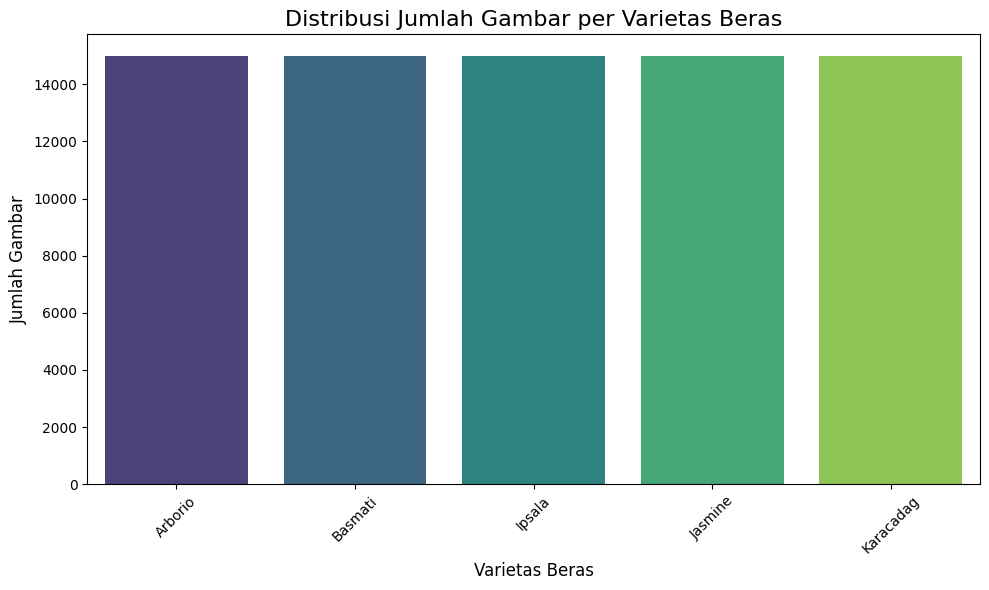

In [4]:
# Pastikan df_summary sudah ada dari langkah sebelumnya
if 'df_summary' in locals():
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Nama Kelas', y='Jumlah Gambar', data=df_summary, palette='viridis')
    
    plt.title('Distribusi Jumlah Gambar per Varietas Beras', fontsize=16)
    plt.xlabel('Varietas Beras', fontsize=12)
    plt.ylabel('Jumlah Gambar', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("DataFrame 'df_summary' tidak ditemukan. Jalankan sel sebelumnya terlebih dahulu.")

**Observasi:** Dari plot di atas, kita dapat melihat bahwa setiap kelas memiliki jumlah gambar yang sama (15.000), yang menandakan ini adalah dataset yang sangat seimbang. Ini bagus karena model tidak akan bias terhadap kelas tertentu.

### Menampilkan Contoh Gambar

Sekarang mari kita lihat seperti apa bentuk gambar dari masing-masing varietas beras.

Menampilkan contoh gambar dari setiap kelas:


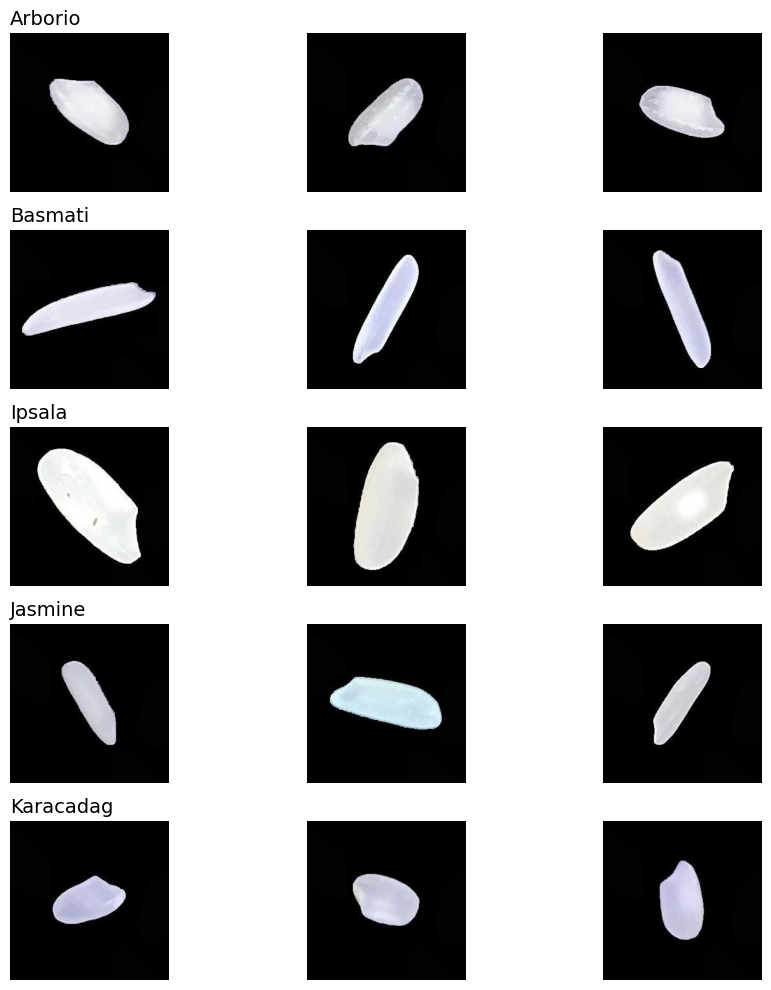

In [6]:
def show_sample_images(base_path, num_samples=3):
    class_names = sorted([d.name for d in base_path.iterdir() if d.is_dir()])
    
    plt.figure(figsize=(10, 2 * len(class_names)))
    
    for i, class_name in enumerate(class_names):
        class_dir = base_path / class_name
        image_files = list(class_dir.glob('*.*'))
        
        sample_images = random.sample(image_files, min(num_samples, len(image_files)))
        
        for j, image_path in enumerate(sample_images):
            ax = plt.subplot(len(class_names), num_samples, i * num_samples + j + 1)
            img = Image.open(image_path)
            plt.imshow(img)
            plt.axis("off")
            if j == 0:
                plt.title(class_name, loc='left', fontsize=14)
                
    plt.tight_layout()
    plt.show()

# Panggil fungsi untuk menampilkan gambar
if base_dir.exists():
    print("Menampilkan contoh gambar dari setiap kelas:")
    show_sample_images(base_dir)

# **5. Data Preprocessing**

Tahap preprocessing utama untuk proyek ini adalah **membagi dataset** menjadi tiga bagian: data latih (`train`), data validasi (`val`), dan data uji (`test`). Ini adalah langkah krusial sebelum melatih model machine learning.

Selain itu, kita juga akan mendefinisikan proses **augmentasi data** dan **normalisasi**, yang akan diterapkan saat data dimuat untuk training.

### Pemisahan Dataset (Data Splitting)

Kita akan menulis logika untuk menyalin file gambar dari dataset sumber ke struktur folder baru (`data_split/`) dengan rasio 70% untuk training, 15% untuk validasi, dan 15% untuk testing.

In [7]:
SOURCE_DIR = Path('Rice_Image_Dataset')
TARGET_DIR = Path('data_split')
SPLIT_RATIOS = (0.7, 0.15, 0.15)  # (train, val, test)

print(f"Mempersiapkan untuk membagi dataset...")
print(f"Rasio: Train={SPLIT_RATIOS[0]}, Validation={SPLIT_RATIOS[1]}, Test={SPLIT_RATIOS[2]}")

# Hapus direktori target jika sudah ada untuk memulai dari awal
if TARGET_DIR.exists():
    shutil.rmtree(TARGET_DIR)
    print(f"Menghapus direktori lama: {TARGET_DIR}")

# Proses setiap kelas (subfolder)
class_dirs = [d for d in SOURCE_DIR.iterdir() if d.is_dir()]

for class_dir in tqdm(class_dirs, desc="Memproses semua kelas"):
    class_name = class_dir.name
    images = list(class_dir.glob('*.*'))
    random.shuffle(images)

    total = len(images)
    train_end = int(SPLIT_RATIOS[0] * total)
    val_end = train_end + int(SPLIT_RATIOS[1] * total)

    splits = {
        'train': images[:train_end],
        'val': images[train_end:val_end],
        'test': images[val_end:]
    }

    for split_name, split_files in splits.items():
        split_class_dir = TARGET_DIR / split_name / class_name
        split_class_dir.mkdir(parents=True, exist_ok=True)
        for file_path in split_files:
            shutil.copy2(file_path, split_class_dir)

print("\nPemisahan dataset selesai.")

Mempersiapkan untuk membagi dataset...
Rasio: Train=0.7, Validation=0.15, Test=0.15


Memproses semua kelas: 100%|████████████████████████████████████████████████████████| 5/5 [00:30<00:00,  6.02s/it]


Pemisahan dataset selesai.


In [8]:
# Verifikasi jumlah file di setiap set
for split in ['train', 'val', 'test']:
    total_files = len(list((TARGET_DIR / split).glob('**/*.*')))
    print(f"Total gambar di folder '{split}': {total_files}")

Total gambar di folder 'train': 52500
Total gambar di folder 'val': 11250
Total gambar di folder 'test': 11250


### Persiapan `ImageDataGenerator`

Setelah file-file terorganisir, kita siapkan `ImageDataGenerator`. Alat dari Keras ini akan memuat gambar dari folder, melakukan normalisasi (mengubah skala piksel dari 0-255 menjadi 0-1), dan menerapkan augmentasi data secara *real-time* pada data training.

In [9]:
# Definisikan generator dengan augmentasi untuk data training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Definisikan generator tanpa augmentasi untuk data validasi dan test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Buat generator yang memuat data dari direktori
train_generator = train_datagen.flow_from_directory(
    TARGET_DIR / 'train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    TARGET_DIR / 'val',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TARGET_DIR / 'test',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print("\nData generator siap digunakan untuk training model.")

Found 52500 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.

Data generator siap digunakan untuk training model.


**Penjelasan:**

  * **`rescale=1./255`**: Ini adalah langkah normalisasi yang sangat penting.
  * **`rotation_range`, `zoom_range`, `horizontal_flip`**: Ini adalah teknik augmentasi untuk membuat model kita lebih tahan terhadap variasi gambar (posisi, orientasi, dll.) dan mengurangi overfitting. Augmentasi hanya diterapkan pada set `train`.
  * **`flow_from_directory`**: Metode ini sangat efisien karena memuat gambar dalam *batch* (kelompok kecil), sehingga tidak membebani memori RAM meskipun datasetnya sangat besar.